In [2]:
!pip install xgboost imbalanced-learn lightgbm shap

Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import shap

Upload Your Dataset

In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/Cancer_Data.csv')

# Quick check
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nColumns:", df.columns.tolist())

Dataset shape: (569, 33)

First 5 rows:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst 

Clean and Prepare the Dataset

In [5]:
# Drop useless columns
df = df.drop(['id', 'Unnamed: 32'], axis=1)

# Encode diagnosis: M (malignant) = 1, B (benign) = 0
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])

# Quick check after cleaning
print("New shape after cleaning:", df.shape)
print("\nClass distribution (0 = Benign, 1 = Malignant):")
print(df['diagnosis'].value_counts())
print("\nFirst 5 rows after cleaning:")
print(df.head())

New shape after cleaning: (569, 31)

Class distribution (0 = Benign, 1 = Malignant):
diagnosis
0    357
1    212
Name: count, dtype: int64

First 5 rows after cleaning:
   diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030       

Exploratory Data Analysis (EDA)
Now that the data is clean, let's understand it better with some visualizations and insights. This step helps identify important patterns, correlations, and which features might be most useful for prediction.

/tmp/ipython-input-3702878483.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='diagnosis', data=df, palette='Set2')


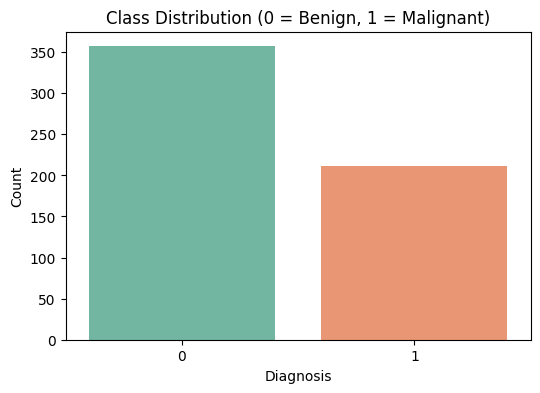

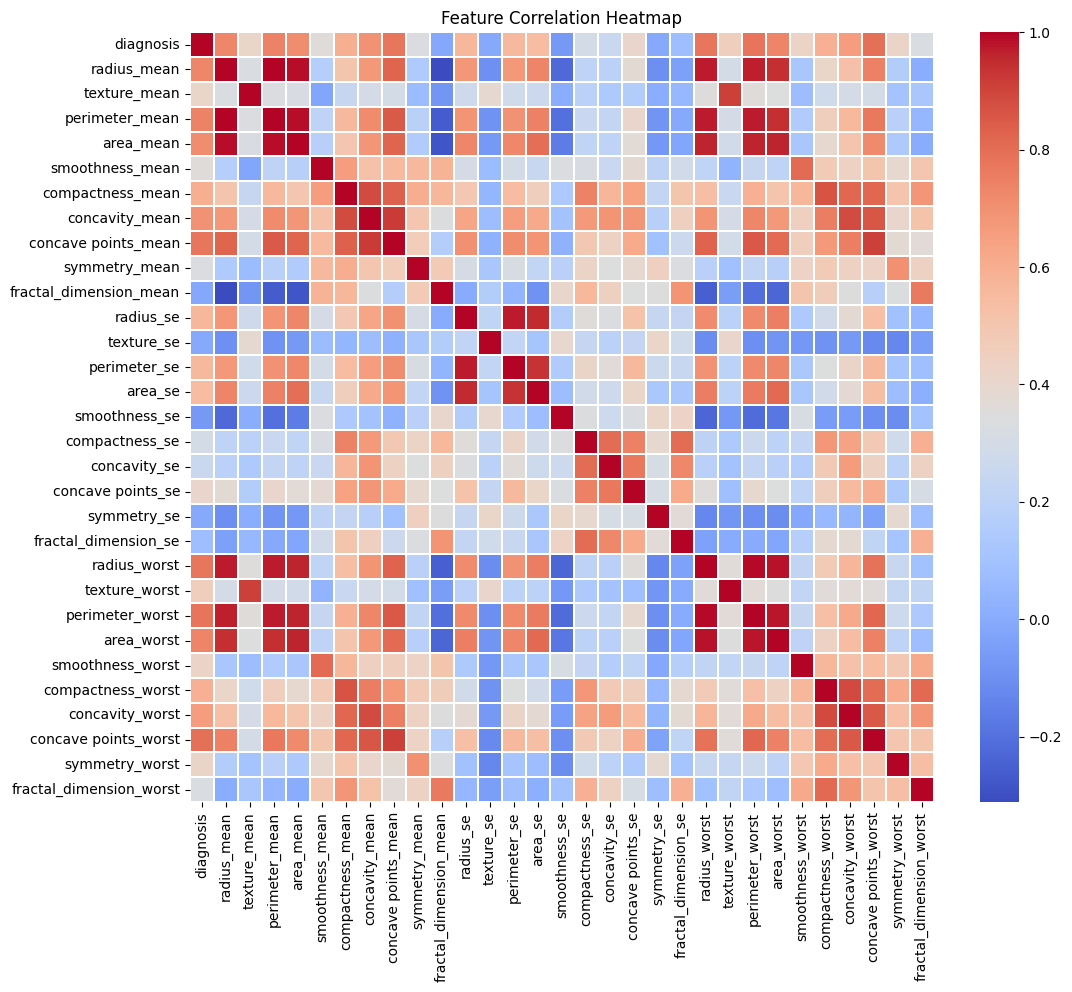

/tmp/ipython-input-3702878483.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=feature, data=df, palette='Set2')
/tmp/ipython-input-3702878483.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=feature, data=df, palette='Set2')
/tmp/ipython-input-3702878483.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=feature, data=df, palette='Set2')
/tmp/ipython-input-3702878483.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Ass

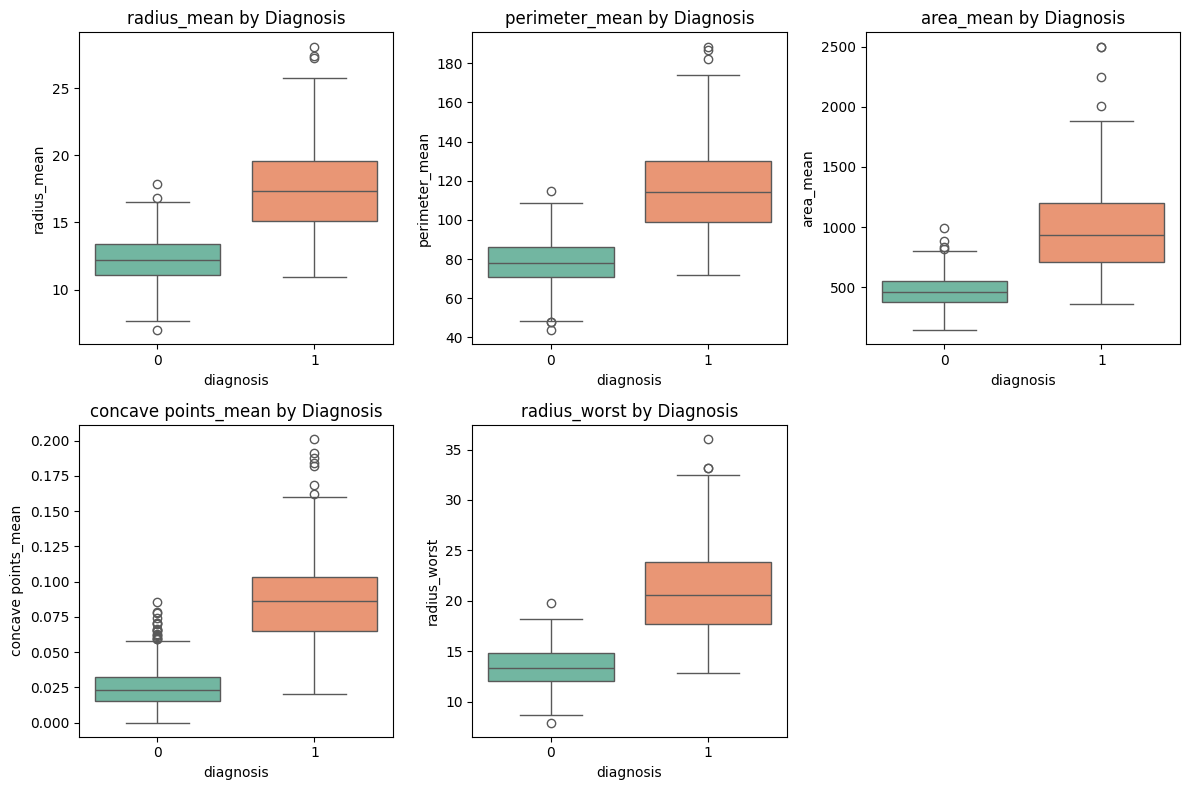

Top 10 features most correlated with diagnosis:
diagnosis               1.000000
concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
concavity_mean          0.696360
concavity_worst         0.659610
Name: diagnosis, dtype: float64


In [6]:
# 1. Class distribution bar plot
plt.figure(figsize=(6,4))
sns.countplot(x='diagnosis', data=df, palette='Set2')
plt.title('Class Distribution (0 = Benign, 1 = Malignant)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

# 2. Correlation heatmap (only numeric features)
plt.figure(figsize=(12,10))
correlation = df.corr()
sns.heatmap(correlation, annot=False, cmap='coolwarm', linewidths=0.1)
plt.title('Feature Correlation Heatmap')
plt.show()

# 3. Boxplot of a few important features by diagnosis
important_features = ['radius_mean', 'perimeter_mean', 'area_mean', 'concave points_mean', 'radius_worst']
plt.figure(figsize=(12,8))
for i, feature in enumerate(important_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='diagnosis', y=feature, data=df, palette='Set2')
    plt.title(f'{feature} by Diagnosis')
plt.tight_layout()
plt.show()

# 4. Print top correlated features with diagnosis
print("Top 10 features most correlated with diagnosis:")
print(correlation['diagnosis'].abs().sort_values(ascending=False).head(11))  # 11 to include diagnosis itself

Data Splitting, Scaling & Handling Imbalance

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Features (X) and target (y)
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Split: 80% train, 20% test (stratified to keep class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features (fit on train only, transform both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to oversample the minority class (malignant) in training set only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Quick verification prints
print("Original training set shape:", X_train.shape)
print("After SMOTE training set shape:", X_train_resampled.shape)
print("Original class distribution in train:", pd.Series(y_train).value_counts())
print("After SMOTE class distribution:", pd.Series(y_train_resampled).value_counts())
print("Test set shape:", X_test.shape)

Original training set shape: (455, 30)
After SMOTE training set shape: (570, 30)
Original class distribution in train: diagnosis
0    285
1    170
Name: count, dtype: int64
After SMOTE class distribution: diagnosis
1    285
0    285
Name: count, dtype: int64
Test set shape: (114, 30)


Baseline Model Comparison & Initial Accuracy Check

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pandas as pd

# Define models (all good performers on this dataset)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=200, random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=200, random_state=42, verbose=-1)
}

# Store results
results = []
for name, model in models.items():
    # Use 5-fold CV on resampled data, score on F1 (best for medical data)
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='f1')
    mean_f1 = cv_scores.mean()
    std_f1 = cv_scores.std()
    results.append({'Model': name, 'Mean F1-Score': mean_f1, 'Std': std_f1})

    # Also check accuracy for reference
    acc_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    print(f"{name}: CV F1 = {mean_f1:.4f} (±{std_f1:.4f}) | Accuracy = {acc_scores.mean():.4f}")

# Show results as table
results_df = pd.DataFrame(results)
print("\nSummary Table (sorted by F1):")
print(results_df.sort_values('Mean F1-Score', ascending=False))

Logistic Regression: CV F1 = 0.9718 (±0.0105) | Accuracy = 0.9719
SVM (RBF): CV F1 = 0.9736 (±0.0076) | Accuracy = 0.9737
Random Forest: CV F1 = 0.9757 (±0.0182) | Accuracy = 0.9754
XGBoost: CV F1 = 0.9756 (±0.0200) | Accuracy = 0.9754


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

LightGBM: CV F1 = 0.9788 (±0.0145) | Accuracy = 0.9789

Summary Table (sorted by F1):
                 Model  Mean F1-Score       Std
4             LightGBM       0.978842  0.014480
2        Random Forest       0.975668  0.018235
3              XGBoost       0.975628  0.020041
1            SVM (RBF)       0.973600  0.007650
0  Logistic Regression       0.971767  0.010517


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Hyperparameter Tuning for the Top Model (LightGBM)

In [9]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Define the LightGBM model
lgbm = LGBMClassifier(random_state=42, verbose=-1)

# Parameter grid (focused on the most impactful params)
param_grid = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 10, -1],          # -1 means no limit
    'num_leaves': [20, 31, 50],
    'min_child_samples': [10, 20, 30]
}

# Grid search with 5-fold CV, optimizing for F1
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,          # Use all CPU cores
    verbose=1
)

# Fit on resampled data
grid_search.fit(X_train_resampled, y_train_resampled)

# Best results
print("Best hyperparameters:", grid_search.best_params_)
print("Best CV F1-score:", grid_search.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 10, 'n_estimators': 300, 'num_leaves': 31}
Best CV F1-score: 0.9822614530055546


Train the Tuned LightGBM Model & Evaluate on Test Set

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


=== Final Model Performance on Test Set ===
Accuracy:       0.9737 (97.37%)
Precision:      1.0000
Recall:         0.9286
F1-Score:       0.9630
ROC-AUC:        0.9924

Classification Report:
               precision    recall  f1-score   support

   Benign (0)       0.96      1.00      0.98        72
Malignant (1)       1.00      0.93      0.96        42

     accuracy                           0.97       114
    macro avg       0.98      0.96      0.97       114
 weighted avg       0.97      0.97      0.97       114



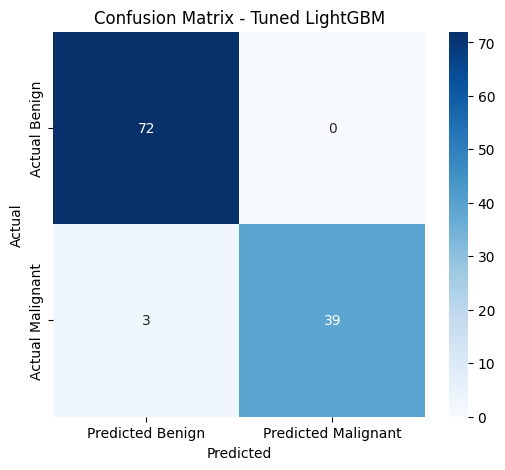

In [10]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Use the best hyperparameters from GridSearch
best_params = {
    'learning_rate': 0.1,
    'max_depth': 10,
    'min_child_samples': 10,
    'n_estimators': 300,
    'num_leaves': 31,
    'random_state': 42,
    'verbose': -1
}

# Train the final model on the resampled training data
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train_resampled, y_train_resampled)

# Predict on the real test set
y_pred = final_model.predict(X_test_scaled)
y_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]  # Probability for malignant

# Calculate key metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print results
print("=== Final Model Performance on Test Set ===")
print(f"Accuracy:       {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1-Score:       {f1:.4f}")
print(f"ROC-AUC:        {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign (0)', 'Malignant (1)']))

# Confusion Matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Benign', 'Predicted Malignant'],
            yticklabels=['Actual Benign', 'Actual Malignant'])
plt.title('Confusion Matrix - Tuned LightGBM')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Feature Importance & SHAP Explainability (for Research Paper)

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


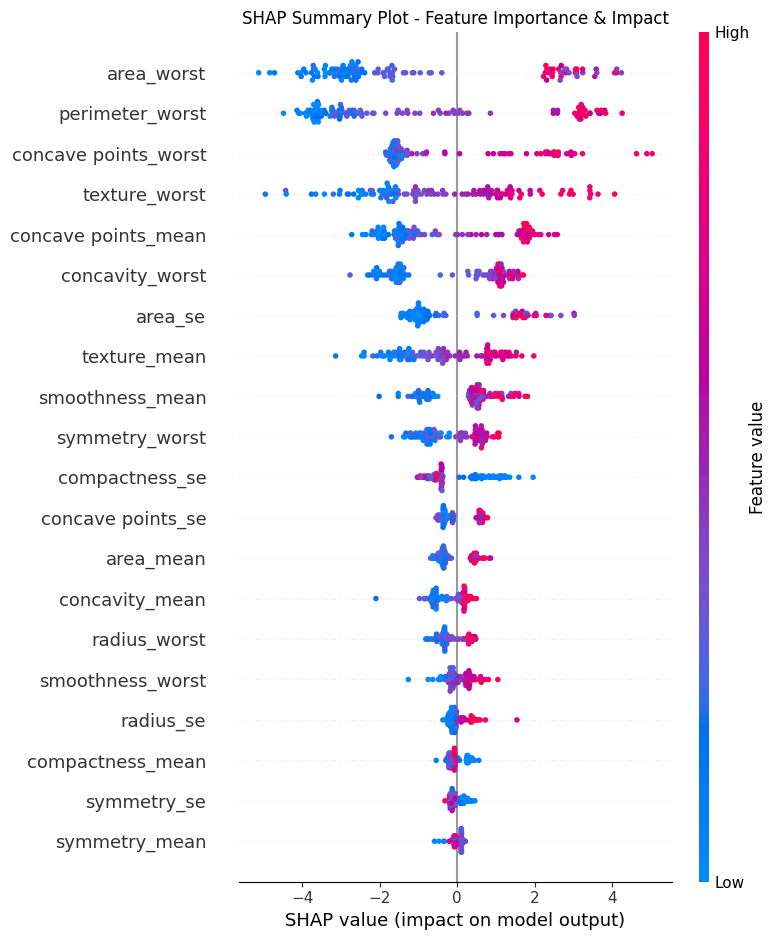

/tmp/ipython-input-2840375378.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=shap_importance.head(10), palette='viridis')


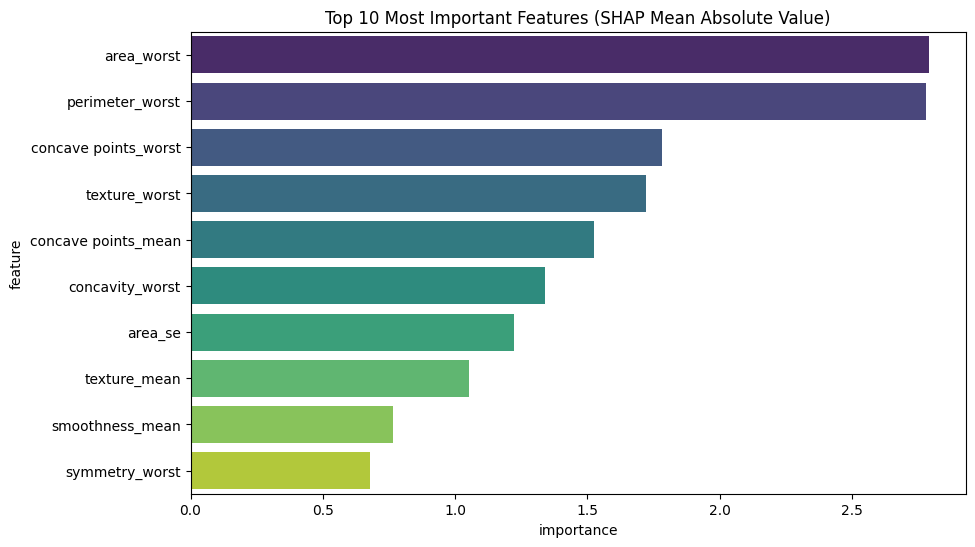

Top 10 most important features (by SHAP):
                 feature  importance
23            area_worst    2.789029
22       perimeter_worst    2.778335
27  concave points_worst    1.781937
21         texture_worst    1.722165
7    concave points_mean    1.525757
26       concavity_worst    1.338632
13               area_se    1.223716
1           texture_mean    1.052943
4        smoothness_mean    0.764931
28        symmetry_worst    0.676282


In [11]:
import shap
import matplotlib.pyplot as plt

# SHAP explainer for LightGBM (TreeExplainer is fast & accurate)
explainer = shap.TreeExplainer(final_model)

# Compute SHAP values on the test set (use scaled data)
shap_values = explainer.shap_values(X_test_scaled)

# 1. Summary plot (beeswarm) - shows feature importance & impact direction
plt.figure(figsize=(10,8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, show=False)
plt.title("SHAP Summary Plot - Feature Importance & Impact")
plt.tight_layout()
plt.show()

# 2. Top 10 feature importance bar plot
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(shap_values).mean(0)
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=shap_importance.head(10), palette='viridis')
plt.title('Top 10 Most Important Features (SHAP Mean Absolute Value)')
plt.show()

# Optional: Print top 10 features
print("Top 10 most important features (by SHAP):")
print(shap_importance.head(10))

Save the Final Model & Scaler (for Reproducibility)

In [12]:
import joblib

# Save the tuned model and scaler
joblib.dump(final_model, 'VitaShield_AI_LightGBM_model.pkl')
joblib.dump(scaler, 'VitaShield_AI_scaler.pkl')

print("Model and scaler saved successfully! Download them from the Files panel.")

Model and scaler saved successfully! Download them from the Files panel.
